In [1]:
clean_up=True # removes gams-related files in work-folder if true
%run StdPackages.ipynb
os.chdir(directory['py'])
import techdata_to_tree, sys, ShockFunction
import abatement_EOP as abatement
os.chdir(directory['curr'])
def flatten_list(list_):
    return [item for sublist in list_ for item in sublist]

The file_gams_py_gdb0.gdx is still active and was not deleted.
The file_gams_py_gdb1.gdx is still active and was not deleted.


*Specify settings:*

In [2]:
name = 'A1_EOP'
f = {'tech': directory['data']+"/techdata_dors_2.xlsx",
     'other': directory['data']+"/Othdata_dors_2.xlsx"}
s = ['inputdisp','endofpipe','inputprices']
m = ['ID','EOP'] 
e = {'M': 'vars','M_sets': 'sets'} # dictionary used to load emissions data
other_trees = {'ID_Y': {'s': 'Y', 'read_data': {'Y': 'vars'}, 'Q2P': 'Q2P'}} # the key = tree name, s = sheet that specifies tree structure, read_data (if not None) specifies how to load data.

In [3]:
type_f = {'ID_EC': 'CES_norm',
          'ID_CU': 'MNL',
          'ID_TU': 'CET_norm',
          'ID_TX': 'CES',
          'ID_BU': 'linear_out',
          'ID_BX': 'CES',
          'EOP_CU': 'MNL',
          'EOP_TU': 'CET_norm',
          'EOP_TX': 'CES'}

*Set up nesting tree:*

In [4]:
%run ATree.ipynb

## 1: Initialize model

*Initialize with ID and EOP technologies:*

In [5]:
gm = abatement.abate(nts=nts,tech=tech,work_folder=directory['work'],use_EOP=True,**{'data_folder':directory['gams'],'name': name})
gm.add_aliases([('n','nnnn'),('n','nnnnn')])
gm.model.database.update_all_sets(clean_up=False) 

*Provide initial values:*

In [6]:
gm.initialize_variables_leontief()
gm.initialize_variables(**{'check_variables': True})

## 2: Solve model

*Debugging:*

In [7]:
# gm.model.database['testminobj'] = 0;

#### 2.1: Baseline

*Set up baseline model and solve:*

In [8]:
gm.write_and_run(name='baseline_EOP')
db0 = gm.model_instances['baseline_EOP'].out_db

*Read back solution to main db:*

In [9]:
gm.model.database.merge_dbs(gm.model.database,db0,'second')

#### 2.2: ID calibrate

In [10]:
gm.reset_settings()
gm.setstate('ID_calibrate',init=False)
gm.write_and_run(name='ID_calibrate',kwargs_init={'check_variables':True},overwrite=True)
db_ID = gm.model_instances['ID_calibrate'].out_db

#### 2.2: ID calibrate

*Change to EOP calibration state and resolve:*

In [11]:
gm.reset_settings()
gm.setstate('EOP_calibrate',init=False)
gm.write_and_run(name='EOP_calibrate',kwargs_init={'check_variables':True},overwrite=True)
db_EOP = gm.model_instances['EOP_calibrate'].out_db

In [12]:
def compare_plots(db0,db,var):
    return pd.concat([db0.get(var).rename(f"{var}, B"),db.get(var).rename(f"{var}, C")],axis=1).plot.bar();

<AxesSubplot:xlabel='n'>

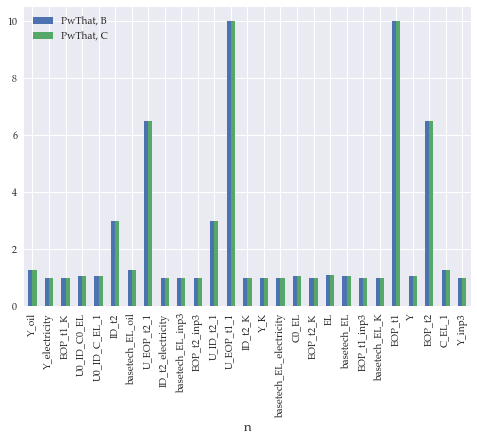

In [13]:
var = 'PwThat'
compare_plots(db_ID,db_EOP,var)

In [17]:
db_EOP.get('currapp_EOP')

z    n     
CO2  EOP_t1    3.148355e-22
     EOP_t2    2.959763e-10
Name: currapp_EOP, dtype: float64

In [17]:
db_EOP.get('currapp_EOP')

z    n     
CO2  EOP_t1    3.148355e-22
     EOP_t2    2.959763e-10
Name: currapp_EOP, dtype: float64

<AxesSubplot:xlabel='n'>

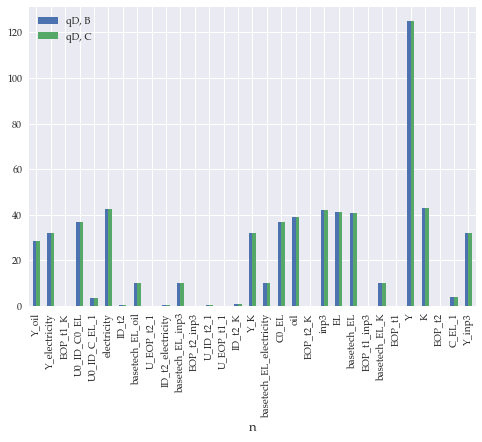

In [14]:
var = 'qD'
compare_plots(db_ID,db_EOP,var)

*Adding the EOP module comes with two types of adjustments: First, there are completely new block of equations to be written. For instance, the solution to the tree structure problem. Second, there are adjustments that replace equations that are applied in the simple ID case:*

To do:
* Keep 'ID\_sum', 'ID\_Em', 'ID\_calib\_aux'.
* Add EOP-ID module that computes aggregate use of inputs (qD[ai]) and the effective price of emissions (pMhat). In the model blocks, replace the ID\_agg with this new one that does both.
* Add EOP module that computes currapp.
* Add specific EOP module that computes post-abatement emissions, the amount of abated emissions, and  the effective price on emission inputs PwThat.
* Add EOP-ID module that computes the minobj for calibration purposes

*Specifically:*

* init\_agg method adjusts according to state. 
* init\_EOP\_emissions class includes computation of PwThat for inputs (similar to ID class), as well as post-abatement emissions, effective price on emissions, and abated emissions.
* init\_EOP\_calib_aux computes currapp\_EOP.
* init\_minobj method adjusts according to state.